In [63]:
from src.harness import architecture as arch
from src.harness import history
import src.harness.seeding as seed
from src.harness import utils
from src.metrics import trial_aggregations as t_agg
from src.metrics import experiment_aggregations as e_agg
from src.plotting import base_plots as bp

import copy
import functools
from importlib import reload
import itertools
from matplotlib import pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import os
import tensorflow as tf
from typing import Any, Dict, Callable, Generator, Iterable, List, Tuple

In [64]:
epath = os.path.join(
    os.getenv("HOME"),
    "lottery-tickets/experiments/11-04-2024/lenet_mnist_0_seed_5_experiments_1_batches_0.025_default_sparsity_lm_pruning_20241102-111614",
    "models",
    "model0",
)
print(os.listdir(epath))

['trial3', 'trial6', 'trial9', 'trial14', 'trial12', 'trial2', 'trial11', 'initial', 'trial17', 'trial16', 'trial13', 'trial5', 'trial8', 'trial10', 'trial1', 'trial4', 'trial7', 'trial0', 'trial15']


In [67]:
path_prefix = os.path.join(
    os.getenv("HOME"),
    "lottery-tickets",
    "experiments",
    "seeding_fail",
)
experiment_paths = os.listdir(path_prefix)

In [68]:
reload(seed)

WeightTrackingCallback = Tuple[
    str,
    Callable[
        [
            List[np.ndarray[bool]],
            history.TrialData,
        ],
        Any,
    ],
]

def prop_weights_in_mask(
    tracking_masks: List[np.ndarray], 
    trial: history.TrialData,
) -> List[float]:
    return [
        np.sum(mask[target]) / np.sum(target) 
        for target, mask in zip(tracking_masks, trial.masks)
    ]

def layerwise_sparsity(
    masks: List[np.ndarray[bool]], 
    trial: history.TrialData
) -> List[float]:
    return [np.sum(m) / m.size for m in trial.masks]

def trace_weights_over_time(
    tracking_masks: List[np.ndarray], 
    trials: Iterable[history.TrialData],
    callbacks: List[WeightTrackingCallback],
) -> Dict[str, np.ndarray]:
    data = {}
        
    for index, trial in enumerate(trials):
        for name, callback in callbacks:
            if data.get(name) is None:
                data[name] = []
            data[name].append(callback(tracking_masks, trial))
    return data

def compile_trace_weights(
    select_weights: seed.WeightsTarget,
    experiments: List[Generator[history.TrialData, None, None]],
    callbacks: List[WeightTrackingCallback],
) -> Dict:
    trial_values = []
    for experiment in experiments:
        trial = next(experiment)
        # Temp: Remove with new trials
        a = arch.Architecture(trial.architecture, trial.dataset)
        utils.set_seed(trial.random_seed)
        model = a.get_model_constructor()()
        initial_weights = model.get_weights()
        masks = [select_weights(w) for w in initial_weights]
        trials = itertools.chain([trial], experiment)
        results = trace_weights_over_time(masks, trials, callbacks)
        trial_values.append(results)
    return trial_values

def plot_seeded_vs_overall_sparsity(
    targets_2d: np.ndarray[np.ndarray[np.ndarray]],
    sparsity_2d: np.ndarray[np.ndarray[np.ndarray]],
    model_name: str,
    save_location: str = None,
):
    null_cols = [i for i, is_null in enumerate(np.isnan(targets_2d[0, 0])) if is_null]
    sparsity_2d = np.delete(sparsity_2d, null_cols, axis=2)
    targets_2d = np.delete(targets_2d, null_cols, axis=2)

    agg_mean_targets = np.mean(targets_2d, axis=0)
    agg_mean_actual = np.mean(sparsity_2d, axis=0)
    agg_std_targets = np.std(targets_2d, axis=0)
    agg_std_actual = np.std(sparsity_2d, axis=0)
    num_samples = targets_2d.shape[0]

    all_layers = [
        name for index, name 
        in enumerate(arch.Architecture.get_model_layers(model_name)) 
        if index not in null_cols
    ]

    plt.figure()
    plt.title(f"Overall Sparsity vs. Seeded Sparsity in {model_name}")
    plt.xlabel("Overall Layer Sparsity (%)")
    plt.ylabel("Seeded Layer Sparsity (%)")

    for index, label in enumerate(all_layers):
        bp.plot_aggregated_summary_ci(
            agg_mean_actual[:, index], 
            agg_mean_targets[:, index], 
            agg_std_targets[:, index], 
            num_samples,
            legend=label,
            show_ci_legend=False,
        )

    plt.legend()
    if save_location is not None:
        plt.savefig(save_location)
    plt.show()


conv4_fashion_mnist_0_seed_5_experiments_1_batches_0.025_default_sparsity_lm_pruning_20241104-185455


/tmp/ipykernel_355/2294387576.py:19: RuntimeWarning: invalid value encountered in divide
  np.sum(mask[target]) / np.sum(target)


conv6_mnist_0_seed_5_experiments_1_batches_0.025_default_sparsity_lm_pruning_20241104-185455
conv2_mnist_0_seed_5_experiments_1_batches_0.025_default_sparsity_lm_pruning_20241104-185455


FileNotFoundError: [Errno 2] No such file or directory: '/gpfs1/home/j/b/jbourde2/lottery-tickets/experiments/seeding_fail/conv2_mnist_0_seed_5_experiments_1_batches_0.025_default_sparsity_lm_pruning_20241104-185455/plots/seeded_weights_sparsity.png'

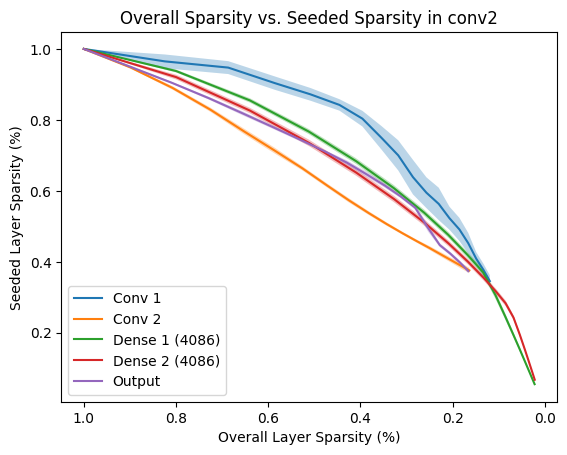

In [70]:
callbacks = [
    ("prop_target_remaining", prop_weights_in_mask),
    ("sparsity", layerwise_sparsity),
]

for ename in experiment_paths:
    print(ename)
    epath = os.path.join(path_prefix, ename)
    results = compile_trace_weights(
        functools.partial(seed.target_magnitude, proportion=0.2, target=seed.Target.HIGH),
        history.get_experiments(epath),
        callbacks,
    )

    sparsity_2d = np.array([
        d["sparsity"]
        for d in results
    ])
    targets_2d = np.array([
        d["prop_target_remaining"]
        for d in results
    ])
    model_name = ename.split("_")[0]
    save_location = os.path.join(epath, "plots", "seeded_weights_sparsity.png")
    if not os.path.exists(save_location):
        plot_seeded_vs_overall_sparsity(targets_2d, sparsity_2d, model_name, save_location)


In [ ]:

trial = next(history.get_trials(epath))
a = arch.Architecture(trial.architecture, trial.dataset)
utils.set_seed(trial.random_seed)
model = a.get_model_constructor()()
initial_weights = model.get_weights()
tracking_masks = [seed.target_magnitude(w, 0.2, seed.Target.HIGH) for w in initial_weights]
results = trace_weights_over_time(tracking_masks, history.get_trials(epath), callbacks)

overall_sparsities = results["sparsity"]
tracked_sparsities = results["prop_target_remaining"]
indices = [i for i, v in enumerate(tracked_sparsities[0]) if not np.isnan(v)]

all_layers = arch.Architecture.get_model_layers("lenet")
layer_labels = [name for i, name in enumerate(all_layers) if i in indices]
sparsities = [np.array(a)[indices] for a in overall_sparsities]

diffs = []
for expected_sparsity, actual_sparsity in zip(overall_sparsities, tracked_sparsities):
    e = np.array(expected_sparsity)
    a = np.array(actual_sparsity)
    non_nan_indices = ~np.isnan(a)
    a = a[non_nan_indices]
    e = e[non_nan_indices]
    diff = a - e
    diffs.append(diff)

sparsities = np.array(sparsities) * 100
diffs = np.array(diffs) * 100

plt.figure()
plt.title("Proportion of Tracked Weights vs. Overall Sparsity")
plt.xlabel("Layer Sparsity (% Params Remaining)")
plt.ylabel("Tracked Param Sparsity - Layer Sparsity")

for index, label in enumerate(layer_labels):
    x = sparsities[:, index]
    y = diffs[:, index]
    plt.plot(x, y, label=label)
    
plt.gca().invert_xaxis()
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.gca().xaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend()
plt.show()


In [14]:
model_arch = arch.Architecture("lenet", "mnist")
model = model_arch.get_model_constructor()()
initial_weights = model.get_weights()

In [13]:
from importlib import reload

reload(seed)

weights = copy.deepcopy(initial_weights)

seed.seed_magnitude(
    weights, 
    0.2, 
    seed.Target.HIGH, 
    functools.partial(seed.scale_magnitude, factor=2)
)